<a href="https://colab.research.google.com/github/sonyharianto1991/multicriteria_healthcheck/blob/main/03_multi_metrics_composite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Metrics Monitoring — Composite Score (D_prod)

Notebook ini fokus ke **multi metrics** (PSI, KL, class shift, confidence ratio, latency) dan menghitung **Composite Health Score (D_prod)** untuk beberapa skenario.

In [7]:
# (Opsional) Install dependencies jika jalan di Colab
# !pip install -q torch torchvision scikit-learn tqdm numpy pandas matplotlib pillow scipy

import os, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from PIL import ImageEnhance, ImageFilter, Image
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import ImageEnhance
import random

## 1) Helper Metrics: PSI, KL, Class Shift, Confidence Ratio, Latency

In [8]:
def clamp01(x: float) -> float:
    return max(0.0, min(1.0, float(x)))

def compute_hist(prob_array: np.ndarray, n_bins: int = 10):
    hist, _ = np.histogram(prob_array, bins=n_bins, range=(0.0, 1.0), density=True)
    hist = np.clip(hist, 1e-12, None)
    hist = hist / hist.sum()
    return hist

def psi_score(expected: np.ndarray, actual: np.ndarray, n_bins: int = 10) -> float:
    e = compute_hist(expected, n_bins=n_bins)
    a = compute_hist(actual, n_bins=n_bins)
    return float(np.sum((a - e) * np.log(a / e)))

def kl_divergence(p: np.ndarray, q: np.ndarray, n_bins: int = 10) -> float:
    p_hist = compute_hist(p, n_bins=n_bins)
    q_hist = compute_hist(q, n_bins=n_bins)
    return float(entropy(p_hist, q_hist))

def class_shift(y_base: np.ndarray, y_scen: np.ndarray, num_classes: int) -> float:
    base_dist = np.bincount(y_base, minlength=num_classes) / max(1, len(y_base))
    scen_dist = np.bincount(y_scen, minlength=num_classes) / max(1, len(y_scen))
    return float(np.abs(scen_dist - base_dist).sum() / 2.0)  # total variation distance (0..1)

@torch.no_grad()
def run_inference_collect(model, dataloader, device):
    model.eval()
    all_probs=[]
    all_pred=[]
    lat_ms=[]
    for x,_ in tqdm(dataloader, desc="infer", leave=False):
        x = x.to(device)
        t0 = time.time()
        logits = model(x)
        torch.cuda.synchronize() if device.type == "cuda" else None
        t1 = time.time()
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        pred = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_pred.append(pred)
        lat_ms.append((t1 - t0) * 1000.0)
    all_probs = np.vstack(all_probs)
    all_pred = np.concatenate(all_pred)
    lat_ms = np.array(lat_ms)
    return all_probs, all_pred, lat_ms


## 2) Normalisasi & Composite Score (Weighted Sum)

In [14]:
@dataclass
class ProductionMetrics:
    psi: float
    kl: float
    class_shift: float
    ratio_conf: float
    p95_latency_ms: float

def norm_bad(x: float, lo: float, hi: float) -> float:
    # semakin besar semakin buruk -> map ke 0..1 (0 bagus)
    if hi <= lo:
        return 0.0
    return clamp01((x - lo) / (hi - lo))

def norm_good(x: float, lo: float, hi: float) -> float:
    # semakin besar semakin baik -> map ke 0..1 (1 bagus)
    if hi <= lo:
        return 1.0
    return clamp01((x - lo) / (hi - lo))

# Parameter normalisasi (isi sesuai hasil baseline/eksperimen)
NORM = {
    "psi": (0.0, 1.0),          # contoh range
    "kl": (0.0, 0.5),
    "class_shift": (0.0, 0.2),
    "ratio_conf": (0.7, 1.0),   # good metric
    "p95_latency_ms": (200.0, 800.0),  # bad metric
}

# Bobot WSM (silakan sesuaikan dengan tesis)
W = {
    "stability": 0.35,   # PSI + KL + class_shift
    "confidence": 0.20,  # ratio_conf
    "latency": 0.20,     # p95_latency
    "error": 0.15,       # reserved (kalau ada error rate)
    "biz": 0.10,         # reserved (kalau ada biz KPI)
}

def compute_d_prod(m: ProductionMetrics) -> float:
    # Stability component: gabungkan beberapa drift metrics jadi 1 nilai buruk
    psi_n = norm_bad(m.psi, *NORM["psi"])
    kl_n  = norm_bad(m.kl, *NORM["kl"])
    cs_n  = norm_bad(m.class_shift, *NORM["class_shift"])
    stab_bad = float(np.mean([psi_n, kl_n, cs_n]))          # 0 bagus, 1 buruk
    stab_good = 1.0 - stab_bad                              # 1 bagus

    conf_good = norm_good(m.ratio_conf, *NORM["ratio_conf"]) # 1 bagus

    lat_bad = norm_bad(m.p95_latency_ms, *NORM["p95_latency_ms"])
    lat_good = 1.0 - lat_bad

    # error & biz belum dipakai -> set netral 1.0 (good) agar tidak mengganggu
    err_good = 1.0
    biz_good = 1.0

    wsum = W["stability"] + W["confidence"] + W["latency"] + W["error"] + W["biz"]
    w = {k: v/wsum for k,v in W.items()}

    d = (
        w["stability"]  * stab_good +
        w["confidence"] * conf_good +
        w["latency"]    * lat_good +
        w["error"]      * err_good +
        w["biz"]        * biz_good
    )
    return float(clamp01(d))

def status_from_dprod(d: float) -> str:
    # Threshold contoh (silakan sesuaikan)
    if d >= 0.80:
        return "Healthy"
    if d >= 0.60:
        return "Degraded"
    return "Critical"


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3) Load Baseline Model & Baseline Reference

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 2
MODEL_PATH = "mobilenet_baseline.pth"

model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device).eval()

DATA_DIR = "/content/drive/MyDrive/TESIS/dataset"  # TODO
BASELINE_DIR = os.path.join(DATA_DIR, "test")

IMG_SIZE = 224
BATCH_SIZE = 32

base_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

baseline_ds = datasets.ImageFolder(BASELINE_DIR, transform=base_tfms)
baseline_loader = DataLoader(baseline_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

base_probs, base_pred, base_lat_ms = run_inference_collect(model, baseline_loader, device)
base_max_conf = base_probs.max(axis=1)
base_mean_conf = float(base_max_conf.mean())


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


infer:   0%|          | 0/3 [00:00<?, ?it/s]

## 4) Definisi Skenario Degradasi

In [16]:
class PILLighting:
    def __init__(self, factor: float): self.factor = factor
    def __call__(self, img): return ImageEnhance.Brightness(img).enhance(self.factor)

class PILBlur:
    def __init__(self, radius: float): self.radius = radius
    def __call__(self, img): return img.filter(ImageFilter.GaussianBlur(radius=self.radius))

class PILJPEG:
    def __init__(self, quality: int): self.quality = int(quality)
    def __call__(self, img):
        import io
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=self.quality)
        buf.seek(0)
        return Image.open(buf).convert("RGB")

class PILGaussianNoise:
    def __init__(self, sigma: float): self.sigma = float(sigma)
    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.sigma, size=arr.shape).astype(np.float32)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(arr)

def make_scenario_tfms(pil_aug):
    return transforms.Compose([
        pil_aug,
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

scenarios = {
    "Lighting Degradation": make_scenario_tfms(PILLighting(factor=0.1)),
    "Blur Degradation": make_scenario_tfms(PILBlur(radius=2.0)),
    "Compression (JPEG)": make_scenario_tfms(PILJPEG(quality=25)),
    "Gaussian Noise": make_scenario_tfms(PILGaussianNoise(sigma=15.0)),
}


## 4.1) Preview: Visual Comparison of Degradation Scenarios

Visualisasi berikut menampilkan perbandingan antara gambar asli dengan 4 skenario degradasi:
- **Lighting**: Penurunan brightness (factor=0.1)
- **Blur**: Gaussian blur (radius=2.0)  
- **Compression**: JPEG compression (quality=25)
- **Noise**: Gaussian noise (sigma=15.0)

In [ ]:
# Preview: Comparison between Original vs Degradation Scenarios
# Load a few sample images to visualize the degradation effects

# Create a simple transform for original images (no degradation, just resize for display)
preview_base_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

# Load dataset without normalization for visualization
preview_ds = datasets.ImageFolder(BASELINE_DIR, transform=preview_base_tfm)

# Select random samples to display
num_samples = 4
indices = random.sample(range(len(preview_ds)), num_samples)

# Create subplot: 1 column for original + 4 columns for degradations = 5 columns total
fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

degradation_list = [
    ("Lighting", PILLighting(factor=0.1)),
    ("Blur", PILBlur(radius=2.0)),
    ("Compression", PILJPEG(quality=25)),
    ("Noise", PILGaussianNoise(sigma=15.0)),
]

for row, idx in enumerate(indices):
    # Load original image
    orig_img, label = preview_ds[idx]
    class_name = preview_ds.classes[label]
    
    # Show original
    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"Original\n{class_name}", fontsize=10)
    axes[row, 0].axis("off")
    
    # Show each degradation
    for col, (deg_name, deg_transform) in enumerate(degradation_list, start=1):
        degraded_img = deg_transform(orig_img)
        axes[row, col].imshow(degraded_img)
        axes[row, col].set_title(f"{deg_name}\n{class_name}", fontsize=10)
        axes[row, col].axis("off")

plt.suptitle("Degradation Scenarios Comparison", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 5) Jalankan Multi-Metrics + Composite Score

In [17]:
rows=[]
for scen_name, tfms in scenarios.items():
    scen_ds = datasets.ImageFolder(BASELINE_DIR, transform=tfms)
    scen_loader = DataLoader(scen_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    probs, pred, lat_ms = run_inference_collect(model, scen_loader, device)
    max_conf = probs.max(axis=1)
    mean_conf = float(max_conf.mean())
    ratio_conf = mean_conf / base_mean_conf if base_mean_conf > 0 else float("nan")

    psi = psi_score(base_max_conf, max_conf, n_bins=10)
    kl  = kl_divergence(base_max_conf, max_conf, n_bins=10)
    cs  = class_shift(base_pred, pred, NUM_CLASSES)
    p95_lat = float(np.percentile(lat_ms, 95))

    m = ProductionMetrics(psi=psi, kl=kl, class_shift=cs, ratio_conf=ratio_conf, p95_latency_ms=p95_lat)
    d_prod = compute_d_prod(m)

    rows.append({
        "Scenario": scen_name,
        "PSI (↑ drift)": psi,
        "KL (↑ drift)": kl,
        "Class Shift (0-1)": cs,
        "Confidence Ratio": ratio_conf,
        "P95 Latency (ms)": p95_lat,
        "D_prod (0-1)": d_prod,
        "Status": status_from_dprod(d_prod),
    })

df_multi = pd.DataFrame(rows).sort_values("D_prod (0-1)")
df_multi


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0c36c953a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0c36c953a0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): 
  

infer:   0%|          | 0/3 [00:00<?, ?it/s]

    ^ ^^ ^  ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process' 
                 ^ ^^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: can only test a child process^^
^
AssertionError: can only test a child process


infer:   0%|          | 0/3 [00:00<?, ?it/s]

infer:   0%|          | 0/3 [00:00<?, ?it/s]

infer:   0%|          | 0/3 [00:00<?, ?it/s]

,Scenario,PSI (↑ drift),KL (↑ drift),Class Shift (0-1),Confidence Ratio,P95 Latency (ms),D_prod (0-1),Status
3,Gaussian Noise,2.219165,0.106260,0.092105,0.946486,561.997485,0.648469,Degraded
2,Compression (JPEG),1.068868,0.046688,0.013158,0.981134,970.849705,0.652186,Degraded
0,Lighting Degradation,0.024373,0.012976,0.144737,0.998208,1084.548426,0.708504,Degraded
1,Blur Degradation,0.784387,0.068477,0.026316,0.961992,516.392636,0.746356,Degraded


## 6) Visualisasi (Opsional)

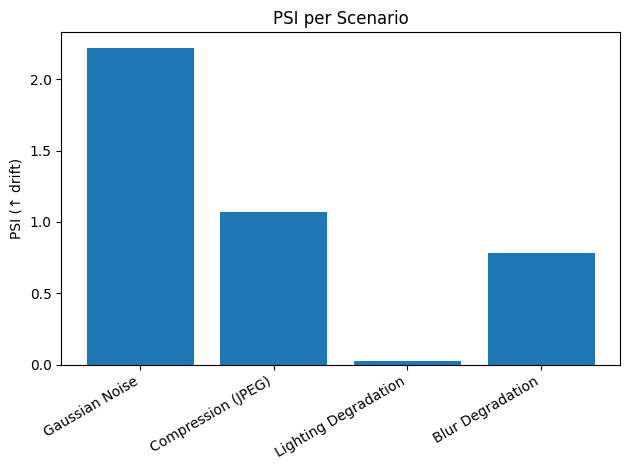

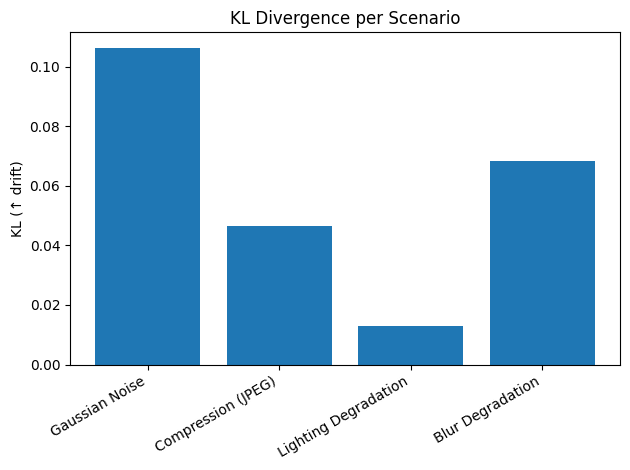

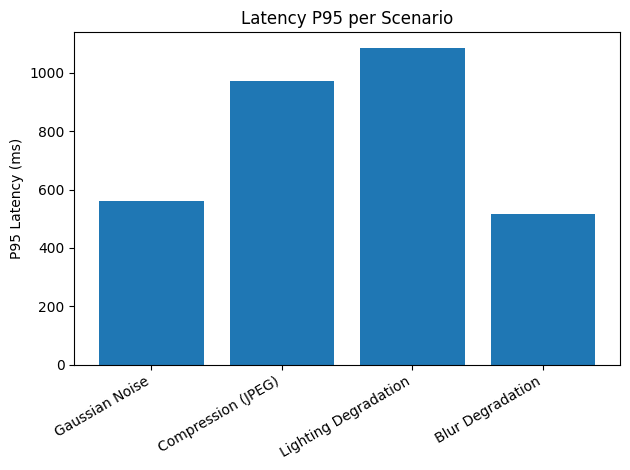

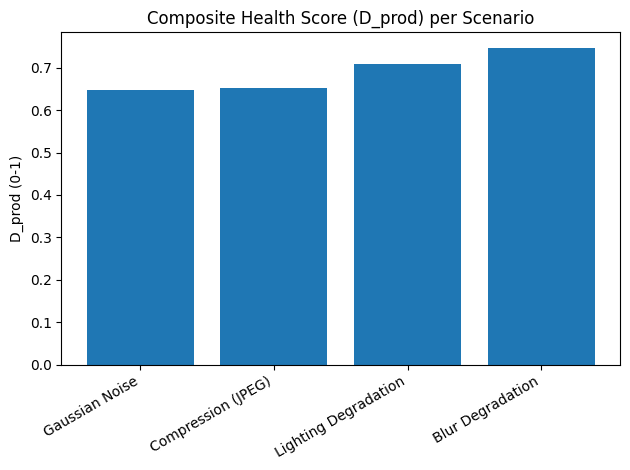

In [18]:
def barplot(metric_col, title):
    fig = plt.figure()
    plt.bar(df_multi["Scenario"], df_multi[metric_col])
    plt.xticks(rotation=30, ha="right")
    plt.title(title)
    plt.ylabel(metric_col)
    plt.tight_layout()
    plt.show()

barplot("PSI (↑ drift)", "PSI per Scenario")
barplot("KL (↑ drift)", "KL Divergence per Scenario")
barplot("P95 Latency (ms)", "Latency P95 per Scenario")
barplot("D_prod (0-1)", "Composite Health Score (D_prod) per Scenario")
